In [3]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import warnings
warnings.filterwarnings('ignore')
from os.path import isfile

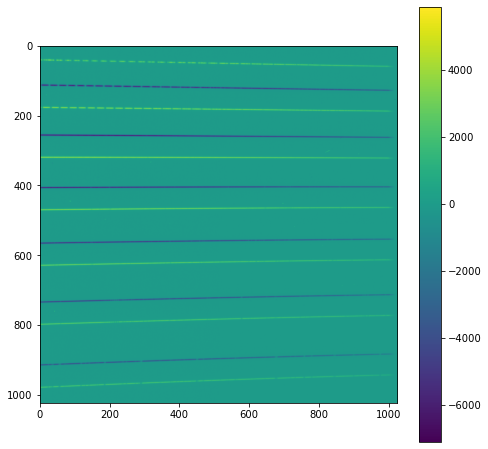

In [11]:
notebook_path = os.path.abspath('h3p.ipynb')
filepath = os.path.join(os.path.dirname(notebook_path), '02jun17/spec/')


hdu_list1 = fits.open(filepath + 'jun02s0043.fits', ignore_missing_end=True)
hdu_list2 = fits.open(filepath + 'jun02s0044.fits', ignore_missing_end=True)
hdu_list3 = fits.open(filepath + 'jun02s0045.fits', ignore_missing_end=True)
hdu_list4 = fits.open(filepath + 'jun02s0046.fits', ignore_missing_end=True)

hdu_list5 = fits.open(filepath + 'jun02s0047.fits', ignore_missing_end=True)
hdu_list6 = fits.open(filepath + 'jun02s0048.fits', ignore_missing_end=True)
hdu_list7 = fits.open(filepath + 'jun02s0049.fits', ignore_missing_end=True)
hdu_list8 = fits.open(filepath + 'jun02s0050.fits', ignore_missing_end=True)


data1 = hdu_list1[0].data
data2 = hdu_list2[0].data
data3 = hdu_list3[0].data
data4 = hdu_list4[0].data

data5 = hdu_list5[0].data
data6 = hdu_list6[0].data
data7 = hdu_list7[0].data
data8 = hdu_list8[0].data

sum_A = data1 + data4 + data5 + data8
sum_B = data2 + data3 + data6 + data7

plt.figure(figsize=(8,8))
plt.imshow(sum_B - sum_A)
plt.colorbar()

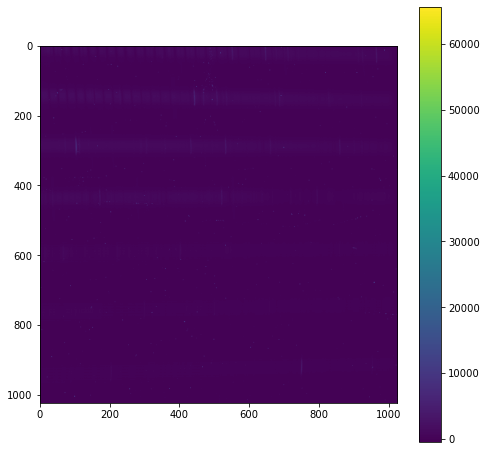

In [13]:
hdul = fits.open(filepath + 'jun02s0052.fits', ignore_missing_end=True)
data = hdul[0].data

plt.figure(figsize=(8,8))
plt.imshow(data)
plt.colorbar()

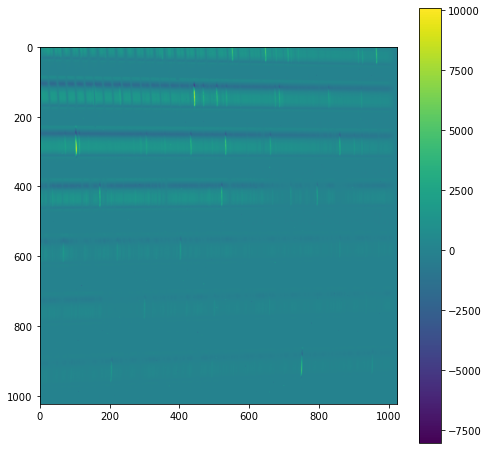

In [6]:
notebook_path = os.path.abspath('h3p.ipynb')
filepath = os.path.join(os.path.dirname(notebook_path), '02jun17/spec/')


hdu_list1 = fits.open(filepath + 'jun02s0051.fits', ignore_missing_end=True)
hdu_list2 = fits.open(filepath + 'jun02s0052.fits', ignore_missing_end=True)
hdu_list3 = fits.open(filepath + 'jun02s0053.fits', ignore_missing_end=True)
hdu_list4 = fits.open(filepath + 'jun02s0054.fits', ignore_missing_end=True)

hdu_list5 = fits.open(filepath + 'jun02s0055.fits', ignore_missing_end=True)
hdu_list6 = fits.open(filepath + 'jun02s0056.fits', ignore_missing_end=True)
hdu_list7 = fits.open(filepath + 'jun02s0057.fits', ignore_missing_end=True)
hdu_list8 = fits.open(filepath + 'jun02s0058.fits', ignore_missing_end=True)


data1 = hdu_list1[0].data
data2 = hdu_list2[0].data
data3 = hdu_list3[0].data
data4 = hdu_list4[0].data

data5 = hdu_list5[0].data
data6 = hdu_list6[0].data
data7 = hdu_list7[0].data
data8 = hdu_list8[0].data

sum_A = data1 + data4 + data5 + data8
sum_B = data2 + data3 + data6 + data7

plt.figure(figsize=(8,8))
plt.imshow(sum_B - sum_A)
plt.colorbar()

['/Users/RuoyanWang/Documents/LEICESTER/h3p/02jun17/spec/jun02s0043.fits', '/Users/RuoyanWang/Documents/LEICESTER/h3p/02jun17/spec/jun02s0044.fits', '/Users/RuoyanWang/Documents/LEICESTER/h3p/02jun17/spec/jun02s0045.fits', '/Users/RuoyanWang/Documents/LEICESTER/h3p/02jun17/spec/jun02s0046.fits', '/Users/RuoyanWang/Documents/LEICESTER/h3p/02jun17/spec/jun02s0047.fits', '/Users/RuoyanWang/Documents/LEICESTER/h3p/02jun17/spec/jun02s0048.fits', '/Users/RuoyanWang/Documents/LEICESTER/h3p/02jun17/spec/jun02s0049.fits', '/Users/RuoyanWang/Documents/LEICESTER/h3p/02jun17/spec/jun02s0050.fits']


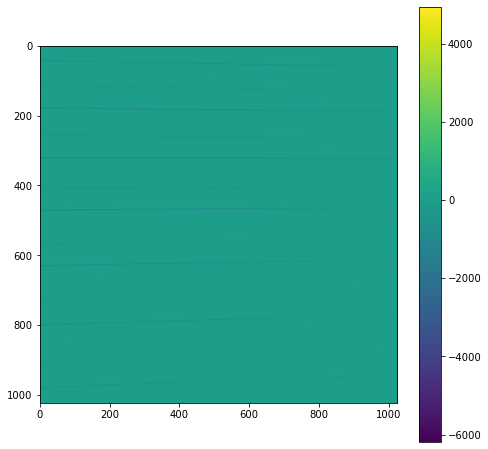

In [215]:
expected_hdul = [filepath + 'jun02s00' + '{}.fits'.format(i) for i in range(43, 51)]
actual_hdul = [f for f in expected_files if isfile(f)]
print (actual_hdul)

abba1 = []
for i in range(0,4):
    abba1.append(fits.open(actual_hdul[i], ignore_missing_end=True)[0].data)
abba1_sum = sum(abba1)

abba2 = []
for i in range(4,8):
    abba2.append(fits.open(actual_hdul[i], ignore_missing_end=True)[0].data)
abba2_sum = sum(abba2)

plt.figure(figsize=(8,8))
plt.imshow(abba2_sum - abba1_sum)
plt.colorbar()